In [1]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

import requests
import tarfile

# Download and extract the file
url = "http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/metis-5.1.0.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

# Change working directory
%cd metis-5.1.0

# The remaining steps as you have shown in the question, with updated path
!make config shared=1 prefix=~/.local/
!make install
!cp ~/.local/lib/libmetis.so /usr/lib/libmetis.so
!export METIS_DLL=/usr/lib/libmetis.so
!pip3 install metis-python
%cd ..

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.7/510.7 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.1/777.1 kB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.8/215.8 kB 25.4 MB/s eta 0:00:00
/content/metis-5.1.0
rm -rf build/Linux-x86_64
mkdir -p build/Linux-x86_64
cd build/Linux-x86_64 && cmake /content/metis-5.1.0 -DCMAKE_VERBOSE_MAKEFILE=1 -DGKLIB_PATH=/content/metis-5.1.0/GKlib -DCMAKE_INSTALL_PREFIX=/root/.local/ -DSHARED=1
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a .

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, Flickr, Reddit, NELL
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, SGConv
from torch_geometric.utils import to_networkx, from_networkx
import metispy as metis
import time
from torch.nn import Sequential as Seq, Linear, ReLU
from itertools import product
import numpy as np
import matplotlib as plt
import networkx as nx
import json
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_nodes, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_nodes)
        self.conv2 = GCNConv(hidden_nodes, num_classes)

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_nodes, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_nodes)
        self.conv2 = SAGEConv(hidden_nodes, num_classes)

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GIN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_nodes, num_classes):
        super(GIN, self).__init__()
        nn1 = Seq(Linear(num_node_features, hidden_nodes), ReLU(), Linear(hidden_nodes, hidden_nodes))
        self.conv1 = GINConv(nn1)
        nn2 = Seq(Linear(hidden_nodes, hidden_nodes), ReLU(), Linear(hidden_nodes, num_classes))
        self.conv2 = GINConv(nn2)

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class SGC(torch.nn.Module):
    def __init__(self, num_node_features, hidden_nodes, num_classes):
        super(SGC, self).__init__()
        self.conv1 = SGConv(num_node_features, num_classes, K=2, cached=True)

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

device: cuda


In [4]:

# Function to load datasets
def load_dataset(name, parts):
    # parts = 1
    if name in ['Cora', 'CiteSeer', 'PubMed']:
        return Planetoid(root=f'/tmp/{name}_{parts}', name=name)
    elif name == 'Flickr':
        return Flickr(root=f'/tmp/Flickr_{parts}')
    elif name == 'NELL':
        return NELL(root=f'/tmp/NELL_{parts}')
    elif name == 'Reddit':
        return Reddit(root=f'/tmp/Reddit_{parts}')
    else:
        raise ValueError(f'Unknown dataset: {name}')

def parts_by_metis(data, num_parts):
  assert num_parts > 1
  # Step 2: Use METIS to partition the graph
  adjlist = [[] for _ in range(len(data.x))]
  for i, j in data.edge_index.t().tolist():
      adjlist[i].append(j)

  # Partition the graph into communities using METIS
  (edgecuts, parts) = metis.part_graph(adjlist, num_parts)

  # Rearrange the adjacency matrix into block-diagonal form
  adj_blocks = torch.zeros((len(data.x), len(data.x)))
  for i in range(len(data.x)):
      for j in adjlist[i]:
          if parts[i] == parts[j]:
              adj_blocks[i, j] = 1.0

  # Convert adjacency blocks to edge index format
  edge_index = adj_blocks.nonzero().t()
  data.edge_index = edge_index
  return data


def kernighan_lin_k(graph, k=3):
    # Initial partition (divide nodes evenly into k parts)
    node_list = list(graph.nodes())
    partitions = [set(node_list[i::k]) for i in range(k)]

    best_partitions = [partitions[i].copy() for i in range(k)]
    best_edge_cut = sum(nx.cut_size(graph, partitions[i], set.union(*(partitions[:i] + partitions[i+1:]))) for i in range(k))

    improvement = True
    while improvement:
        improvement = False
        for part_idx in range(k):
            for other_part_idx in range(k):
                if part_idx == other_part_idx:
                    continue

                for node in partitions[part_idx]:
                    # Find best node to swap from part_idx to other_part_idx
                    best_gain = float('inf')
                    best_candidate = None

                    for candidate_node in partitions[other_part_idx]:
                        # Create new partitions after swapping
                        new_partitions = [part.copy() for part in partitions]
                        new_partitions[part_idx].remove(node)
                        new_partitions[part_idx].add(candidate_node)
                        new_partitions[other_part_idx].remove(candidate_node)
                        new_partitions[other_part_idx].add(node)

                        # Calculate the new cut size
                        new_edge_cut = sum(nx.cut_size(graph, new_partitions[i], set.union(*(new_partitions[:i] + new_partitions[i+1:]))) for i in range(k))

                        # Calculate gain (reduction in edge cut)
                        gain = best_edge_cut - new_edge_cut

                        if gain < best_gain:
                            best_gain = gain
                            best_candidate = candidate_node

                    if best_candidate is not None:
                        # Perform the swap if it improves the cut size
                        partitions[part_idx].remove(node)
                        partitions[other_part_idx].add(node)
                        partitions[other_part_idx].remove(best_candidate)
                        partitions[part_idx].add(best_candidate)

                        # Update the best partitions if a better solution is found
                        new_edge_cut = sum(nx.cut_size(graph, partitions[i], set.union(*(partitions[:i] + partitions[i+1:]))) for i in range(k))
                        if new_edge_cut < best_edge_cut:
                            best_edge_cut = new_edge_cut
                            best_partitions = [part.copy() for part in partitions]
                            improvement = True
                            break

                if improvement:
                    break
            if improvement:
                break

    return best_partitions, best_edge_cut

def update_edge_index(data, partitions, G):
    new_edges = []
    for part in partitions:
        for node in part:
            for neighbor in G.neighbors(node):
                if node < neighbor:  # To avoid duplicate edges
                    new_edges.append([node, neighbor])
                    new_edges.append([neighbor, node])

    new_edge_index = torch.tensor(new_edges, dtype=torch.long).t().contiguous()
    data.edge_index = new_edge_index
    return data

def parts_by_kl(data, num_parts=2):
  G = to_networkx(data, to_undirected=True)
  partitions, edge_cut = kernighan_lin_k(G, num_parts)
  data = update_edge_index(data, partitions, G)
  return data

# Function to partition the dataset using METIS and visualize the adjacency matrix
def get_partitioned_dataset(dataset_name, partition_method, num_parts=2, visualize=False):
    # Step 1: Load the Cora dataset
    dataset = load_dataset(dataset_name, num_parts)
    data = dataset[0]

    if num_parts > 1 and num_parts < len(data.x):
      if 'metis' == partition_method:
        data = parts_by_metis(data, num_parts)
      elif 'kernighan–lin' == partition_method:
        data = parts_by_kl(data, num_parts)
      else:
        raise ValueError(f"unknown partition_method: {partition_method}")
    # # Visualization (optional)
    # if visualize:
    #     adj_matrix = np.zeros((len(data.x), len(data.x)))
    #     for i, j in data.edge_index.t().tolist():
    #         adj_matrix[i, j] = 1
    #         adj_matrix[j, i] = 1  # Assuming undirected graph, add symmetrically

    #     sorted_indices = np.argsort(parts)
    #     adj_matrix_sorted = adj_matrix[sorted_indices][:, sorted_indices]

    #     plt.figure(figsize=(10, 10))
    #     plt.imshow(adj_matrix_sorted, cmap='binary', interpolation='none')
    #     plt.title(f'Clustered Adjacency Matrix (Cora Dataset, {num_parts} partitions)')
    #     plt.xlabel('Nodes')
    #     plt.ylabel('Nodes')
    #     plt.xticks(np.arange(0, len(adj_matrix_sorted), 50))
    #     plt.yticks(np.arange(0, len(adj_matrix_sorted), 50))
    #     plt.gca().set_xticklabels(np.arange(0, len(adj_matrix_sorted), 50))
    #     plt.gca().set_yticklabels(np.arange(0, len(adj_matrix_sorted), 50))
    #     plt.gca().tick_params(axis='both', which='both', length=0)
    #     plt.imshow(adj_matrix_sorted, cmap='binary', interpolation='none')
    #     plt.scatter(np.arange(len(sorted_indices)), np.arange(len(sorted_indices)), marker='.', cmap='tab10')
    #     plt.show()

    data = data.to(device)
    return dataset.num_features, dataset.num_classes, data


In [5]:

# Train the model
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    start_time = time.time_ns()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    end_time = time.time_ns()
    return loss, end_time-start_time

# Test the model
def test(model, data, optimizer, criterion):
    model.eval()
    start_time = time.time_ns()
    out = model(data)
    end_time = time.time_ns()
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc, end_time-start_time

def dump_results(results, suffix=""):
  file_path = os.path.abspath(f'./experiment_results_{device}_{suffix}.json')
  with open(file_path, 'w') as f:
      json.dump({"results":results}, f)
  print(f"dumped to {file_path}")

In [6]:
MODEL_LIST = [
    # GCN,
    # GIN,
    # GraphSAGE,
    SGC,
    ]
DATASET_LIST = [
    'Cora',
    'CiteSeer',
    'PubMed',
    # 'Flickr',
    # 'NELL',
    # 'Reddit',
    ]
PARTITION_METHOD_LIST = [
    'metis',
    # 'kernighan–lin',
]

LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
HIDDEN_LAYER_NODES = 16
EPOCHS = 200
NUM_PARTS_LIST = [part_size for part_size in range(1, 10, 1)]+[part_size for part_size in range(10, 100, 10)]+[part_size for part_size in range(100, 1000, 100) ]+[part_size for part_size in range(1000, 10000, 1000) ]+[part_size for part_size in range(10000, 100000, 10000) ]
NUM_ITERATIONS = 3

In [ ]:
experiment_results = []

root_start_time = time.time()

for part_method, model_class, dataset_name in product( PARTITION_METHOD_LIST, MODEL_LIST, DATASET_LIST):
  for num_parts in NUM_PARTS_LIST:
    # Load the Cora dataset
    data_num_node_features, data_num_classes, data  = get_partitioned_dataset(dataset_name, part_method, num_parts)
    if len(data.x) < num_parts:
      break
    data = data.to(device)
    current_result =  {
        'partition_method': str(part_method),
        "GNN": model_class.__name__,
        'dataset': dataset_name,
        'num_parts': num_parts,
        'device':str(device),
        'edges_after_partition': len(data.edge_index[0]),
        'avg_train_loss': 0,
        'time_taken_for_train': 0,
        'time_taken_for_test': 0,
        'test_accuracy': 0,
    }

    for cur_iter in range(NUM_ITERATIONS):
      # Initialize the model, optimizer, and loss function
      gnn_model = model_class(data_num_node_features, HIDDEN_LAYER_NODES, data_num_classes).to(device)
      adam_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
      cross_criterion = torch.nn.CrossEntropyLoss()

      # Training loop
      avg_total_loss = 0
      avg_train_time = 0
      for epoch in range(EPOCHS):
          loss, train_time = train(gnn_model, data, adam_optimizer, cross_criterion)
          avg_total_loss += loss.item()
          avg_train_time += train_time
      avg_total_loss = avg_total_loss / EPOCHS
      train_time = avg_train_time / EPOCHS

      current_result['avg_train_loss'] += avg_total_loss
      current_result['time_taken_for_train'] += train_time

      # Evaluate the model
      accuracy, test_time = test(gnn_model, data, adam_optimizer, cross_criterion)
      current_result['test_accuracy'] += accuracy
      current_result['time_taken_for_test'] += test_time

    current_result['avg_train_loss'] /= NUM_ITERATIONS
    current_result['time_taken_for_train'] /= NUM_ITERATIONS
    current_result['time_taken_for_test'] /= NUM_ITERATIONS
    current_result['test_accuracy'] /= NUM_ITERATIONS

    print(current_result)
    experiment_results.append ( current_result )
    dump_results(experiment_results, '_'.join(cur.__name__ for cur in MODEL_LIST))

root_end_time = time.time()

print("total_mins", (root_end_time-root_start_time))

{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 1, 'device': 'cuda', 'edges_after_partition': 10556, 'avg_train_loss': 0.21055348156640927, 'time_taken_for_train': 2663378.92, 'time_taken_for_test': 178208.66666666666, 'test_accuracy': 0.7983333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 2, 'device': 'cuda', 'edges_after_partition': 10178, 'avg_train_loss': 0.20513168243070443, 'time_taken_for_train': 1417028.1383333334, 'time_taken_for_test': 119865.33333333333, 'test_accuracy': 0.799}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 3, 'device': 'cuda', 'edges_after_partition': 9940, 'avg_train_loss': 0.20083837453275918, 'time_taken_for_train': 1396490.3, 'time_taken_for_test': 117988.0, 'test_accuracy': 0.799}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 4, 'device': 'cuda', 'edges_after_partition': 9906, 'avg_train_loss': 0.1993175644427538, 'time_taken_for_train': 1387984.58, 'time_taken_for_test': 137733.33333333334, 'test_accuracy': 0.793}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 5, 'device': 'cuda', 'edges_after_partition': 9812, 'avg_train_loss': 0.19982140341152746, 'time_taken_for_train': 1423730.9133333333, 'time_taken_for_test': 121301.0, 'test_accuracy': 0.791}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 6, 'device': 'cuda', 'edges_after_partition': 9652, 'avg_train_loss': 0.19917957639942566, 'time_taken_for_train': 1376409.0416666667, 'time_taken_for_test': 119890.0, 'test_accuracy': 0.781}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 7, 'device': 'cuda', 'edges_after_partition': 9604, 'avg_train_loss': 0.19488365543385347, 'time_taken_for_train': 1435618.71, 'time_taken_for_test': 115083.33333333333, 'test_accuracy': 0.7843333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 8, 'device': 'cuda', 'edges_after_partition': 9460, 'avg_train_loss': 0.19492632144441205, 'time_taken_for_train': 1400753.326666667, 'time_taken_for_test': 119251.33333333333, 'test_accuracy': 0.786}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 9, 'device': 'cuda', 'edges_after_partition': 9370, 'avg_train_loss': 0.19335828675578037, 'time_taken_for_train': 1386982.9983333333, 'time_taken_for_test': 118715.66666666667, 'test_accuracy': 0.7856666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 10, 'device': 'cuda', 'edges_after_partition': 9348, 'avg_train_loss': 0.19367368454734482, 'time_taken_for_train': 1408962.1716666666, 'time_taken_for_test': 132424.33333333334, 'test_accuracy': 0.786}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 20, 'device': 'cuda', 'edges_after_partition': 8958, 'avg_train_loss': 0.18984723566720885, 'time_taken_for_train': 1402325.2266666666, 'time_taken_for_test': 116857.0, 'test_accuracy': 0.7766666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 30, 'device': 'cuda', 'edges_after_partition': 8600, 'avg_train_loss': 0.19275154300034048, 'time_taken_for_train': 1411905.6133333333, 'time_taken_for_test': 122034.0, 'test_accuracy': 0.7679999999999999}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 40, 'device': 'cuda', 'edges_after_partition': 8382, 'avg_train_loss': 0.18592261688783765, 'time_taken_for_train': 1400329.2133333336, 'time_taken_for_test': 136297.66666666666, 'test_accuracy': 0.7676666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 50, 'device': 'cuda', 'edges_after_partition': 8132, 'avg_train_loss': 0.18802840231607357, 'time_taken_for_train': 1378352.2216666667, 'time_taken_for_test': 119605.0, 'test_accuracy': 0.7603333333333332}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 60, 'device': 'cuda', 'edges_after_partition': 8054, 'avg_train_loss': 0.180231096552064, 'time_taken_for_train': 1382692.2533333332, 'time_taken_for_test': 116063.0, 'test_accuracy': 0.763}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 70, 'device': 'cuda', 'edges_after_partition': 7788, 'avg_train_loss': 0.18453023957709472, 'time_taken_for_train': 1376345.355, 'time_taken_for_test': 116697.33333333333, 'test_accuracy': 0.7756666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 80, 'device': 'cuda', 'edges_after_partition': 7422, 'avg_train_loss': 0.17915111559132735, 'time_taken_for_train': 1385047.8783333334, 'time_taken_for_test': 116991.66666666667, 'test_accuracy': 0.7516666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 90, 'device': 'cuda', 'edges_after_partition': 6044, 'avg_train_loss': 0.1633076157855491, 'time_taken_for_train': 1390794.4683333333, 'time_taken_for_test': 116876.33333333333, 'test_accuracy': 0.7523333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 100, 'device': 'cuda', 'edges_after_partition': 6138, 'avg_train_loss': 0.16739779942979416, 'time_taken_for_train': 1371276.5966666664, 'time_taken_for_test': 125972.0, 'test_accuracy': 0.7563333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 200, 'device': 'cuda', 'edges_after_partition': 3998, 'avg_train_loss': 0.1503556552094718, 'time_taken_for_train': 1865438.7116666667, 'time_taken_for_test': 132982.66666666666, 'test_accuracy': 0.6866666666666669}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 300, 'device': 'cuda', 'edges_after_partition': 4456, 'avg_train_loss': 0.15041349623352288, 'time_taken_for_train': 1362836.3083333333, 'time_taken_for_test': 121303.33333333333, 'test_accuracy': 0.7263333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 400, 'device': 'cuda', 'edges_after_partition': 3648, 'avg_train_loss': 0.14203636592254043, 'time_taken_for_train': 1426698.4716666667, 'time_taken_for_test': 150765.66666666666, 'test_accuracy': 0.6926666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 500, 'device': 'cuda', 'edges_after_partition': 3344, 'avg_train_loss': 0.13688873413950203, 'time_taken_for_train': 1391844.6233333333, 'time_taken_for_test': 127653.0, 'test_accuracy': 0.6726666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 600, 'device': 'cuda', 'edges_after_partition': 3288, 'avg_train_loss': 0.14344024106860162, 'time_taken_for_train': 1380597.7933333332, 'time_taken_for_test': 129924.66666666667, 'test_accuracy': 0.697}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 700, 'device': 'cuda', 'edges_after_partition': 3358, 'avg_train_loss': 0.1390054710830251, 'time_taken_for_train': 1364523.8283333334, 'time_taken_for_test': 115641.66666666667, 'test_accuracy': 0.664}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 800, 'device': 'cuda', 'edges_after_partition': 3156, 'avg_train_loss': 0.13859879854445656, 'time_taken_for_train': 1447438.6283333332, 'time_taken_for_test': 143142.33333333334, 'test_accuracy': 0.6863333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 900, 'device': 'cuda', 'edges_after_partition': 3100, 'avg_train_loss': 0.13686154201005896, 'time_taken_for_train': 1396424.0416666667, 'time_taken_for_test': 123410.33333333333, 'test_accuracy': 0.645}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 1000, 'device': 'cuda', 'edges_after_partition': 2952, 'avg_train_loss': 0.14534499222412703, 'time_taken_for_train': 1361120.6, 'time_taken_for_test': 116182.0, 'test_accuracy': 0.6670000000000001}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'Cora', 'num_parts': 2000, 'device': 'cuda', 'edges_after_partition': 3138, 'avg_train_loss': 0.13980905060345927, 'time_taken_for_train': 1379722.0, 'time_taken_for_test': 141497.0, 'test_accuracy': 0.644}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!
Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 1, 'device': 'cuda', 'edges_after_partition': 9104, 'avg_train_loss': 0.10736963271473844, 'time_taken_for_train': 1739290.735, 'time_taken_for_test': 115583.66666666667, 'test_accuracy': 0.6636666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 2, 'device': 'cuda', 'edges_after_partition': 9052, 'avg_train_loss': 0.10668194334954025, 'time_taken_for_train': 1662760.0933333335, 'time_taken_for_test': 129003.0, 'test_accuracy': 0.666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 3, 'device': 'cuda', 'edges_after_partition': 9050, 'avg_train_loss': 0.1069871154986322, 'time_taken_for_train': 1951006.7216666667, 'time_taken_for_test': 152339.0, 'test_accuracy': 0.665}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 4, 'device': 'cuda', 'edges_after_partition': 8982, 'avg_train_loss': 0.10682702234014868, 'time_taken_for_train': 1707332.048333333, 'time_taken_for_test': 137625.0, 'test_accuracy': 0.6613333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 5, 'device': 'cuda', 'edges_after_partition': 8952, 'avg_train_loss': 0.10850386626397569, 'time_taken_for_train': 1709201.51, 'time_taken_for_test': 127292.33333333333, 'test_accuracy': 0.6696666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 6, 'device': 'cuda', 'edges_after_partition': 8880, 'avg_train_loss': 0.10331459643940132, 'time_taken_for_train': 1706560.4783333333, 'time_taken_for_test': 120346.0, 'test_accuracy': 0.664}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 7, 'device': 'cuda', 'edges_after_partition': 8796, 'avg_train_loss': 0.10137949517617623, 'time_taken_for_train': 1669736.795, 'time_taken_for_test': 147898.66666666666, 'test_accuracy': 0.6703333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 8, 'device': 'cuda', 'edges_after_partition': 8802, 'avg_train_loss': 0.10404547683894634, 'time_taken_for_train': 1699827.7466666668, 'time_taken_for_test': 146956.33333333334, 'test_accuracy': 0.6746666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 9, 'device': 'cuda', 'edges_after_partition': 8748, 'avg_train_loss': 0.10208352642754714, 'time_taken_for_train': 1728756.915, 'time_taken_for_test': 114654.0, 'test_accuracy': 0.684}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 10, 'device': 'cuda', 'edges_after_partition': 8732, 'avg_train_loss': 0.1007449756624798, 'time_taken_for_train': 1882688.7216666664, 'time_taken_for_test': 151432.33333333334, 'test_accuracy': 0.6733333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 20, 'device': 'cuda', 'edges_after_partition': 8382, 'avg_train_loss': 0.09971324181184171, 'time_taken_for_train': 1714864.03, 'time_taken_for_test': 139619.66666666666, 'test_accuracy': 0.6706666666666669}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 30, 'device': 'cuda', 'edges_after_partition': 8230, 'avg_train_loss': 0.10113561481237411, 'time_taken_for_train': 1706688.3633333333, 'time_taken_for_test': 148634.0, 'test_accuracy': 0.68}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 40, 'device': 'cuda', 'edges_after_partition': 8124, 'avg_train_loss': 0.09738665357232094, 'time_taken_for_train': 1648231.3333333333, 'time_taken_for_test': 117299.33333333333, 'test_accuracy': 0.6816666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 50, 'device': 'cuda', 'edges_after_partition': 7994, 'avg_train_loss': 0.0993869304470718, 'time_taken_for_train': 1671733.3116666665, 'time_taken_for_test': 116524.33333333333, 'test_accuracy': 0.664}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 60, 'device': 'cuda', 'edges_after_partition': 7922, 'avg_train_loss': 0.10046419105182092, 'time_taken_for_train': 1690020.4433333334, 'time_taken_for_test': 121306.0, 'test_accuracy': 0.6633333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 70, 'device': 'cuda', 'edges_after_partition': 7422, 'avg_train_loss': 0.09349186927080154, 'time_taken_for_train': 1691054.0833333333, 'time_taken_for_test': 116964.0, 'test_accuracy': 0.6709999999999999}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 80, 'device': 'cuda', 'edges_after_partition': 7284, 'avg_train_loss': 0.09515991742412248, 'time_taken_for_train': 1937250.6233333333, 'time_taken_for_test': 145662.0, 'test_accuracy': 0.6726666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 90, 'device': 'cuda', 'edges_after_partition': 7726, 'avg_train_loss': 0.09644563724597295, 'time_taken_for_train': 1714912.7233333334, 'time_taken_for_test': 120408.66666666667, 'test_accuracy': 0.674}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 100, 'device': 'cuda', 'edges_after_partition': 7330, 'avg_train_loss': 0.09907320044313868, 'time_taken_for_train': 1698394.2366666666, 'time_taken_for_test': 137807.33333333334, 'test_accuracy': 0.6766666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 200, 'device': 'cuda', 'edges_after_partition': 6646, 'avg_train_loss': 0.09996418321505189, 'time_taken_for_train': 1687567.201666667, 'time_taken_for_test': 122003.33333333333, 'test_accuracy': 0.653}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 300, 'device': 'cuda', 'edges_after_partition': 5446, 'avg_train_loss': 0.08547955793018143, 'time_taken_for_train': 1919523.6616666669, 'time_taken_for_test': 157821.66666666666, 'test_accuracy': 0.6469999999999999}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 400, 'device': 'cuda', 'edges_after_partition': 4882, 'avg_train_loss': 0.08920740839714807, 'time_taken_for_train': 1676470.545, 'time_taken_for_test': 121251.33333333333, 'test_accuracy': 0.6333333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 500, 'device': 'cuda', 'edges_after_partition': 4630, 'avg_train_loss': 0.07943760247901081, 'time_taken_for_train': 1676574.8833333335, 'time_taken_for_test': 115308.33333333333, 'test_accuracy': 0.6283333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 600, 'device': 'cuda', 'edges_after_partition': 4388, 'avg_train_loss': 0.08792772956192492, 'time_taken_for_train': 1831713.7149999999, 'time_taken_for_test': 130767.66666666667, 'test_accuracy': 0.6676666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 700, 'device': 'cuda', 'edges_after_partition': 4382, 'avg_train_loss': 0.07658813774585724, 'time_taken_for_train': 1695411.8783333332, 'time_taken_for_test': 116955.33333333333, 'test_accuracy': 0.6196666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 800, 'device': 'cuda', 'edges_after_partition': 4136, 'avg_train_loss': 0.08130416215086977, 'time_taken_for_train': 1693108.22, 'time_taken_for_test': 122524.0, 'test_accuracy': 0.6233333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 900, 'device': 'cuda', 'edges_after_partition': 4158, 'avg_train_loss': 0.07594574296226105, 'time_taken_for_train': 1798741.8883333334, 'time_taken_for_test': 145594.66666666666, 'test_accuracy': 0.646}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 1000, 'device': 'cuda', 'edges_after_partition': 3974, 'avg_train_loss': 0.08119693574495614, 'time_taken_for_train': 1668347.625, 'time_taken_for_test': 138151.66666666666, 'test_accuracy': 0.637}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 2000, 'device': 'cuda', 'edges_after_partition': 3886, 'avg_train_loss': 0.07163105413628122, 'time_taken_for_train': 1648412.173333333, 'time_taken_for_test': 117561.0, 'test_accuracy': 0.6196666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'CiteSeer', 'num_parts': 3000, 'device': 'cuda', 'edges_after_partition': 3850, 'avg_train_loss': 0.07101863000541925, 'time_taken_for_train': 1662434.9966666668, 'time_taken_for_test': 135875.33333333334, 'test_accuracy': 0.6176666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!
Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 1, 'device': 'cuda', 'edges_after_partition': 88648, 'avg_train_loss': 0.7020113069812458, 'time_taken_for_train': 1609756.4149999998, 'time_taken_for_test': 118063.33333333333, 'test_accuracy': 0.7793333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 2, 'device': 'cuda', 'edges_after_partition': 85878, 'avg_train_loss': 0.6977959739168486, 'time_taken_for_train': 1602048.6483333334, 'time_taken_for_test': 108167.0, 'test_accuracy': 0.7836666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 3, 'device': 'cuda', 'edges_after_partition': 84694, 'avg_train_loss': 0.6973198691010475, 'time_taken_for_train': 1579934.7700000003, 'time_taken_for_test': 111358.33333333333, 'test_accuracy': 0.7800000000000001}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 4, 'device': 'cuda', 'edges_after_partition': 83500, 'avg_train_loss': 0.6965827667713165, 'time_taken_for_train': 1559783.9816666667, 'time_taken_for_test': 128198.33333333333, 'test_accuracy': 0.7833333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 5, 'device': 'cuda', 'edges_after_partition': 81872, 'avg_train_loss': 0.6973171594738959, 'time_taken_for_train': 1582884.9483333332, 'time_taken_for_test': 123445.0, 'test_accuracy': 0.783}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 6, 'device': 'cuda', 'edges_after_partition': 80628, 'avg_train_loss': 0.691699787179629, 'time_taken_for_train': 1548209.2733333334, 'time_taken_for_test': 110339.0, 'test_accuracy': 0.773}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 7, 'device': 'cuda', 'edges_after_partition': 78960, 'avg_train_loss': 0.694360692501068, 'time_taken_for_train': 1551845.3233333332, 'time_taken_for_test': 106861.0, 'test_accuracy': 0.7826666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 8, 'device': 'cuda', 'edges_after_partition': 78490, 'avg_train_loss': 0.691731172601382, 'time_taken_for_train': 1571003.6816666666, 'time_taken_for_test': 156354.0, 'test_accuracy': 0.777}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 9, 'device': 'cuda', 'edges_after_partition': 77824, 'avg_train_loss': 0.6914118296901385, 'time_taken_for_train': 1578358.0200000003, 'time_taken_for_test': 127049.0, 'test_accuracy': 0.7656666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 10, 'device': 'cuda', 'edges_after_partition': 76710, 'avg_train_loss': 0.6932848445574442, 'time_taken_for_train': 1568749.0916666668, 'time_taken_for_test': 128179.33333333333, 'test_accuracy': 0.7719999999999999}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 20, 'device': 'cuda', 'edges_after_partition': 72148, 'avg_train_loss': 0.6863490144411722, 'time_taken_for_train': 1597455.7933333332, 'time_taken_for_test': 112206.66666666667, 'test_accuracy': 0.7723333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 30, 'device': 'cuda', 'edges_after_partition': 69848, 'avg_train_loss': 0.686336029668649, 'time_taken_for_train': 1567029.8800000001, 'time_taken_for_test': 114952.0, 'test_accuracy': 0.7783333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 40, 'device': 'cuda', 'edges_after_partition': 67924, 'avg_train_loss': 0.6788837365309398, 'time_taken_for_train': 1560051.085, 'time_taken_for_test': 127391.0, 'test_accuracy': 0.771}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 50, 'device': 'cuda', 'edges_after_partition': 66332, 'avg_train_loss': 0.6750679992636045, 'time_taken_for_train': 1615940.5416666667, 'time_taken_for_test': 121717.0, 'test_accuracy': 0.7693333333333333}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 60, 'device': 'cuda', 'edges_after_partition': 65228, 'avg_train_loss': 0.6826704361041386, 'time_taken_for_train': 1561176.1616666669, 'time_taken_for_test': 110408.33333333333, 'test_accuracy': 0.765}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 70, 'device': 'cuda', 'edges_after_partition': 64070, 'avg_train_loss': 0.6761433140436809, 'time_taken_for_train': 1560735.4383333332, 'time_taken_for_test': 113490.66666666667, 'test_accuracy': 0.758}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 80, 'device': 'cuda', 'edges_after_partition': 63142, 'avg_train_loss': 0.6768604107697804, 'time_taken_for_train': 1515915.015, 'time_taken_for_test': 109209.66666666667, 'test_accuracy': 0.761}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 90, 'device': 'cuda', 'edges_after_partition': 62420, 'avg_train_loss': 0.6718717085321745, 'time_taken_for_train': 1858293.548333333, 'time_taken_for_test': 145129.66666666666, 'test_accuracy': 0.7653333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 100, 'device': 'cuda', 'edges_after_partition': 61762, 'avg_train_loss': 0.6739772470792135, 'time_taken_for_train': 1584652.7316666667, 'time_taken_for_test': 112285.33333333333, 'test_accuracy': 0.7676666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 200, 'device': 'cuda', 'edges_after_partition': 57164, 'avg_train_loss': 0.6629772770901521, 'time_taken_for_train': 1577776.4149999998, 'time_taken_for_test': 109875.33333333333, 'test_accuracy': 0.7696666666666667}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 300, 'device': 'cuda', 'edges_after_partition': 54222, 'avg_train_loss': 0.6593475315968195, 'time_taken_for_train': 1559138.3683333332, 'time_taken_for_test': 109802.33333333333, 'test_accuracy': 0.7676666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 400, 'device': 'cuda', 'edges_after_partition': 51468, 'avg_train_loss': 0.6557281243801117, 'time_taken_for_train': 1560360.2599999998, 'time_taken_for_test': 109843.33333333333, 'test_accuracy': 0.759}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 500, 'device': 'cuda', 'edges_after_partition': 47126, 'avg_train_loss': 0.6516890252629916, 'time_taken_for_train': 1552222.8566666665, 'time_taken_for_test': 110440.0, 'test_accuracy': 0.7573333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 600, 'device': 'cuda', 'edges_after_partition': 38992, 'avg_train_loss': 0.6412306398650011, 'time_taken_for_train': 1548316.5983333334, 'time_taken_for_test': 109470.66666666667, 'test_accuracy': 0.743}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 700, 'device': 'cuda', 'edges_after_partition': 44582, 'avg_train_loss': 0.6503960898021858, 'time_taken_for_train': 1563156.8933333333, 'time_taken_for_test': 113046.66666666667, 'test_accuracy': 0.757}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 800, 'device': 'cuda', 'edges_after_partition': 41388, 'avg_train_loss': 0.6313708865145843, 'time_taken_for_train': 1559670.4933333334, 'time_taken_for_test': 137117.0, 'test_accuracy': 0.7596666666666666}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 900, 'device': 'cuda', 'edges_after_partition': 35662, 'avg_train_loss': 0.6251424099008243, 'time_taken_for_train': 1582577.923333333, 'time_taken_for_test': 111806.33333333333, 'test_accuracy': 0.763}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


{'partition_method': 'metis', 'GNN': 'SGC', 'dataset': 'PubMed', 'num_parts': 1000, 'device': 'cuda', 'edges_after_partition': 36594, 'avg_train_loss': 0.6156688784062863, 'time_taken_for_train': 1541883.1383333334, 'time_taken_for_test': 114024.33333333333, 'test_accuracy': 0.7653333333333334}
dumped to /content/experiment_results_cuda_SGC.json


Processing...
Done!


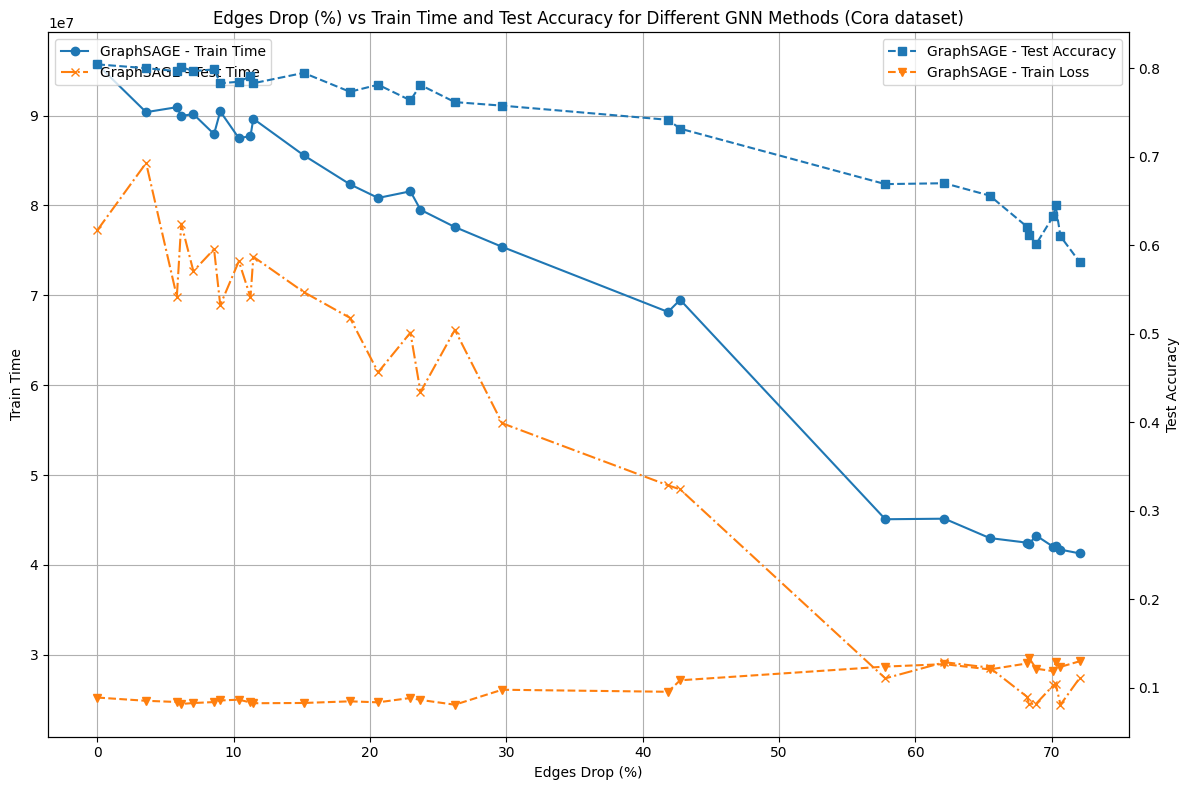

In [110]:
import matplotlib.pyplot as plt

data = experiment_results

# Separate data by GNN method
gnn_methods = {}
for entry in sorted(data, key = lambda x: x['edges_after_partition'], reverse=True):
    gnn = entry["GNN"]
    if gnn not in gnn_methods:
        gnn_methods[gnn] = {"num_parts": [], "edges_after_partition": [], "time_taken_for_train": [], "time_taken_for_test": [], "test_accuracy": [], "avg_train_loss":[]}
    gnn_methods[gnn]["num_parts"].append(entry["num_parts"])
    gnn_methods[gnn]["edges_after_partition"].append(entry["edges_after_partition"])
    gnn_methods[gnn]["time_taken_for_train"].append(entry["time_taken_for_train"])
    gnn_methods[gnn]["time_taken_for_test"].append(entry["time_taken_for_test"])
    gnn_methods[gnn]["test_accuracy"].append(entry["test_accuracy"])
    gnn_methods[gnn]["avg_train_loss"].append(entry["avg_train_loss"])

for gnn, gnn_data in gnn_methods.items():
  total_edges = max( cur_pkt for cur_pkt in gnn_data['edges_after_partition'])
  gnn_data['edge_drop'] = []
  for cur_edges_after_partition in gnn_data['edges_after_partition']:
    gnn_data['edge_drop'].append((total_edges - cur_edges_after_partition)*100/total_edges)
  gnn_methods[gnn] = gnn_data

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot num_parts vs time_taken_for_train
for gnn, values in gnn_methods.items():
    ax1.plot(values["edge_drop"], values["time_taken_for_train"], marker='o', label=f'{gnn} - Train Time')

# Plot num_parts vs time_taken_for_test on ax1
for gnn, values in gnn_methods.items():
    ax1.plot(values["edge_drop"], values["time_taken_for_test"], marker='x', label=f'{gnn} - Test Time', linestyle='-.')

# Create a second y-axis for test_accuracy
ax2 = ax1.twinx()

# Plot num_parts vs test_accuracy
for gnn, values in gnn_methods.items():
    ax2.plot(values["edge_drop"], values["test_accuracy"], marker='s', label=f'{gnn} - Test Accuracy', linestyle='--')
# # Plot num_parts vs test_accuracy
for gnn, values in gnn_methods.items():
    ax2.plot(values["edge_drop"], values["avg_train_loss"], marker='v', label=f'{gnn} - Train Loss', linestyle='--')


# Formatting
# ax1.set_xscale('log', base=2)
# ax1.set_yscale('log')
# ax1.set_xticks([2**i for i in range(11)])
# ax1.set_xticklabels([str(2**i) for i in range(11)])
ax1.set_xlabel('Edges Drop (%)')
ax1.set_ylabel('Train Time')
ax2.set_ylabel('Test Accuracy')
ax1.set_title('Edges Drop (%) vs Train Time and Test Accuracy for Different GNN Methods (Cora dataset)')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
